"FC layers referenced from https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65"


In [72]:
import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
from sklearn.manifold import TSNE
import plotly.io as pio
from sklearn.utils import class_weight
import tqdm as notebook_tqdm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
from model import FCClassifier
from tqdm import tqdm
from graph_context_dataset import FeatureEngineeredDataset
import warnings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Make sure to specify which dataset to use

 - dataset_original
 - dataset_drop_noise
 - dataset_smote

In [2]:
dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"

<h3> Declare functions

In [3]:
class MyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.activation2 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [4]:
class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

class ActivationLayer(nn.Module):
    def __init__(self, activation_fn):
        super(ActivationLayer, self).__init__()
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(x)
        return x

def tanh(x):
    return torch.tanh(x)

def sigmoid(x):
    return torch.sigmoid(x)
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size


In [5]:
def oversample_data(X_train, Y_train, num_classes):
    # Determine the class with the maximum number of instances
    max_class_count = np.max(np.bincount(Y_train))
    # Generate indices for oversampling each class
    indices_list = [np.where(Y_train == i)[0] for i in range(num_classes)]
    # Oversample minority classes to match the count of the majority class
    for i, indices in enumerate(indices_list):
        if len(indices) < max_class_count:
            # Calculate the number of instances to oversample for this class
            num_to_oversample = max_class_count - len(indices)
            # Randomly select instances with replacement to oversample
            oversampled_indices = np.random.choice(indices, size=num_to_oversample, replace=True)
            # Append the oversampled instances to the original data
            X_train = np.concatenate((X_train, X_train[oversampled_indices]), axis=0)
            Y_train = np.concatenate((Y_train, Y_train[oversampled_indices]), axis=0)
    return torch.tensor(X_train), torch.tensor(Y_train)


In [6]:
def concatenate_tensors(tensor_list):
    if not tensor_list:
        raise ValueError("The tensor list is empty")

    feature_dim = tensor_list[0].shape[1]
    for tensor in tensor_list:
        if tensor.shape[1] != feature_dim:
            raise ValueError("All tensors must have the same feature dimension")
    
    concatenated_tensor = torch.cat(tensor_list, dim=0)
    
    return concatenated_tensor

<h4> Import labels and label decoder

In [7]:
file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_val = pickle.load(file)
y_val = torch.tensor(y_val)
    
file_path = 'data/dump/' + dataset_path + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)

<h4> Import the CNNBiLSTM base-node outputs

first we disregard the u' and directly train the h'

In [8]:
train_file_paths = [
    "embed/" + dataset_path + "/u_prime_BERT_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_DGCN_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_edgeAttr_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv2_edgeAttr_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_RGAT_train.pkl",
    "embed/" + dataset_path + "/h_prime_BERT-EGAT_train.pkl",
]

test_file_paths = [
    "embed/" + dataset_path + "/u_prime_BERT_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_DGCN_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_edgeAttr_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv2_edgeAttr_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_RGAT_test.pkl",
    "embed/" + dataset_path + "/h_prime_BERT-EGAT_test.pkl",
]

val_file_paths = [
    "embed/" + dataset_path + "/u_prime_BERT_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_DGCN_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv1_edgeAttr_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_GATv2_edgeAttr_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT_RGAT_dev.pkl",
    "embed/" + dataset_path + "/h_prime_BERT-EGAT_dev.pkl",
]

dictKey = {
    0 : 'bert',
    1 : 'bert-select-few',
    2 : 'bert-select-mod',
    3 : 'bert-select-more',
    4 : 'dgcn',
    5 : 'dgcn-select',
    6 : 'gatv1',
    7 : 'gatv1-select',
    8 : 'gatv1-edge',
    9 : 'gatv1-edge-select',
    10 : 'gatv2-edge',
    11 : 'gatv2-edge-select',
    12 : 'rgat',
    13 : 'rgat-select',
    14 : 'egat',
    15 : 'egat-select',
    16 : 'bert-select-mod-dgcn',
    17 : 'bert-select-mod-gatv1',
    18 : 'bert-select-mod-gatv1-edge',
    19 : 'bert-select-mod-gatv2-edge',
    20 : 'bert-select-mod-rgat',
    21 : 'bert-select-mod-egat',
}

<h4> Getting BERT and GAT outputs for all sets

In [9]:
trainFeaturesList = []
testFeaturesList = []
valFeaturesList = []

In [10]:
def concatenate_tensors(tensor_list):
    return torch.cat(tensor_list, dim=0)

for file_path in train_file_paths:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        if file_path != train_file_paths[-1]: 
            trainFeaturesList.append(concatenate_tensors(data))
        else:
            trainFeaturesList.append(data)
            
for file_path in test_file_paths:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        if file_path != test_file_paths[-1]: 
            testFeaturesList.append(concatenate_tensors(data))
        else:
            testFeaturesList.append(data)
            
for file_path in val_file_paths:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        if file_path != val_file_paths[-1]: 
            valFeaturesList.append(concatenate_tensors(data))
        else:
            valFeaturesList.append(data)

EDA

In [11]:
# # Checking the structure of graph
# for n in range(10):
#     tensor_data_np = tensor_utterances[n].detach().numpy()

#     # Plot the data
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(len(tensor_data_np)), tensor_data_np)
#     plt.title('Line Graph of Tensor Data')
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.show()


In [12]:
# # Normalize the h' (1st GAT)
# data = cherry_picked_nodes.detach().numpy()
# data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# # Compute pairwise cosine similarities
# similarities = cosine_similarity(data_normalized)

# # Print or analyze the similarity matrix
# # print(similarities)
# plt.hist(similarities.flatten(), bins=50, density=True)
# plt.title('Distribution of Cosine Similarities')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()


In [13]:
# # Normalize the h' (2nd GAT)
# data = all_node_feats.detach().numpy()
# data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# # Compute pairwise cosine similarities
# similarities = cosine_similarity(data_normalized)

# # Print or analyze the similarity matrix
# # print(similarities)
# plt.hist(similarities.flatten(), bins=50, density=True)
# plt.title('Distribution of Cosine Similarities')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()


In [14]:
# # Normalize the u' or updated_representations
# data = tensor_utterances.detach().numpy()
# data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# # Compute pairwise cosine similarities
# similarities = cosine_similarity(data_normalized)

# plt.hist(similarities.flatten(), bins=50, density=True)
# plt.title('Distribution of Cosine Similarities')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()


<h3> Feature Selection and creating data combination for classifiers

Define select feature function

In [15]:
def get_norm_features(encoded_features):
    scaler = MinMaxScaler()
#       "FeatureSelected+BERT+GAT: ", concatenatedRepresentationTrain2.shape, "\n",
    features_scaled = scaler.fit_transform(encoded_features)
    return torch.tensor(features_scaled)

def get_selected_features(encoded_features, labels, top_n):
    if torch.is_tensor(encoded_features):
        encoded_features = encoded_features.detach().cpu().numpy()
    
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(encoded_features)

    selector = SelectKBest(score_func=f_classif, k=100)

    top_features_by_class = {}
    top_scores = {}

    for label in range(7):
        # Create a binary mask indicating instances belonging to the current class
        mask = (labels == label)

        # SelectKBest with chi2 as the scoring function
        selector = SelectKBest(score_func=chi2, k=top_n)  # Select top 20 features
        selector.fit(features_scaled, mask)  # Fit SelectKBest to the data
        # Get the indices of the top 20 features
        top_features_indices = np.argsort(selector.scores_)[-top_n:]
        scores = selector.scores_[top_features_indices]
        # Store the indices in the dictionary
        top_features_by_class[label] = top_features_indices
        top_scores[label] = scores

    concatenated_features_set = set()
    for label, indices in top_features_by_class.items():
        concatenated_features_set.update(indices)

    concatenated_features_indices = list(concatenated_features_set)

    concatenated_features_indices = np.array(concatenated_features_indices)

    # Select the desired features
    selected_features = encoded_features[:, concatenated_features_indices]
#     print(selected_features.shape)
    return selected_features, concatenated_features_indices

In [16]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(selected_features.detach().numpy())

# # Plot the PCA result with color-coded labels
# plt.figure(figsize=(8, 6))
# for label in np.unique(Y_train):
#     indices = Y_train == label
#     plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'{label_decoder[label]}', alpha=0.5)
#     plt.title('PCA Visualization of Selected Utterance Embeddings (Train) with Color-Coded Labels')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

3d plottly

In [17]:
# X_train = selected_features
# X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
# # Perform T-SNE dimensionality reduction
# tsne = TSNE(n_components=3, random_state=42)
# X_tsne = tsne.fit_transform(X_train)

# # Create a Plotly scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=X_tsne[:, 0],
#     y=X_tsne[:, 1],
#     z=X_tsne[:, 2],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=Y_train,  # Assuming Y_train contains labels for coloring
#         colorscale='Viridis',  # You can choose a different colorscale
#         opacity=0.8
#     )
# )])

# # Update layout
# fig.update_layout(title='3D T-SNE Plot', autosize=False,
#                   width=800, height=800)

# # Show the plot
# fig.show()

In [18]:
# Save the plot as an HTML file
# pio.write_html(fig, '3d_tsne_plot.html')

Now prepare the data that will be ued to train the classifier, there are 20 combinations. And pick top 7 combinations yielding top F1 weighted-score

In [21]:
trainList = []
testList = []
valList = []

file_path1 = "data/dump/" + dataset_path + "/BERT_data_for_classifier/trainList.pkl"
file_path2 = "data/dump/" + dataset_path + "/BERT_data_for_classifier/testList.pkl"
file_path3 = "data/dump/" + dataset_path + "/BERT_data_for_classifier/valList.pkl"

checkFile1 = os.path.isfile(file_path1)
checkFile2 = os.path.isfile(file_path2)
checkFile3 = os.path.isfile(file_path3)

if checkFile1 and checkFile2 and checkFile3: 
    with open(file_path1, "rb") as file:
        trainList = pickle.load(file)
    with open(file_path2, "rb") as file:
        testList = pickle.load(file)
    with open(file_path3, "rb") as file:
        valList = pickle.load(file)
else:
    trainFeaturesList.append(data)
    #1
    trainList.append(trainFeaturesList[0])
    testList.append(testFeaturesList[0])
    valList.append(valFeaturesList[0])
    #2
    selectedTrainFeatures1a, indicesFeatures1a = get_selected_features(trainFeaturesList[0], y_train, 16)
    selectedTestFeatures1a = testFeaturesList[0][:, indicesFeatures1a]
    selectedValFeatures1a = valFeaturesList[0][:, indicesFeatures1a]
    trainList.append(selectedTrainFeatures1a)
    testList.append(selectedTestFeatures1a)
    valList.append(selectedValFeatures1a)
    #3
    selectedTrainFeatures1b, indicesFeatures1b = get_selected_features(trainFeaturesList[0], y_train, 32)
    selectedTestFeatures1b = testFeaturesList[0][:, indicesFeatures1b]
    selectedValFeatures1b = valFeaturesList[0][:, indicesFeatures1b]
    trainList.append(selectedTrainFeatures1b)
    testList.append(selectedTestFeatures1b)
    valList.append(selectedValFeatures1b)
    #4
    selectedTrainFeatures1c, indicesFeatures1c = get_selected_features(trainFeaturesList[0], y_train, 64)
    selectedTestFeatures1c = testFeaturesList[0][:, indicesFeatures1c]
    selectedValFeatures1c = valFeaturesList[0][:, indicesFeatures1c]
    trainList.append(selectedTrainFeatures1c)
    testList.append(selectedTestFeatures1c)
    valList.append(selectedValFeatures1c)
    #5
    trainList.append(trainFeaturesList[1])
    testList.append(testFeaturesList[1])
    valList.append(valFeaturesList[1])
    #6
    selectedTrainFeatures2, indicesFeatures2 = get_selected_features(trainFeaturesList[1], y_train, 12)
    selectedTestFeatures2 = testFeaturesList[1][:, indicesFeatures2]
    selectedValFeatures2 = valFeaturesList[1][:, indicesFeatures2]
    trainList.append(selectedTrainFeatures2)
    testList.append(selectedTestFeatures2)
    valList.append(selectedValFeatures2)
    #7
    trainList.append(trainFeaturesList[2])
    testList.append(testFeaturesList[2])
    valList.append(valFeaturesList[2])
    #8
    selectedTrainFeatures3, indicesFeatures3 = get_selected_features(trainFeaturesList[2], y_train, 12)
    selectedTestFeatures3 = testFeaturesList[2][:, indicesFeatures3]
    selectedValFeatures3 = valFeaturesList[2][:, indicesFeatures3]
    trainList.append(selectedTrainFeatures3)
    testList.append(selectedTestFeatures3)
    valList.append(selectedValFeatures3)
    #9
    trainList.append(trainFeaturesList[3])
    testList.append(testFeaturesList[3])
    valList.append(valFeaturesList[3])
    #10
    selectedTrainFeatures4, indicesFeatures4 = get_selected_features(trainFeaturesList[3], y_train, 12)
    selectedTestFeatures4 = testFeaturesList[3][:, indicesFeatures4]
    selectedValFeatures4 = valFeaturesList[3][:, indicesFeatures4]
    trainList.append(selectedTrainFeatures4)
    testList.append(selectedTestFeatures4)
    valList.append(selectedValFeatures4)
    #11
    trainList.append(trainFeaturesList[4])
    testList.append(testFeaturesList[4])
    valList.append(valFeaturesList[4])
    #12
    selectedTrainFeatures5, indicesFeatures5 = get_selected_features(trainFeaturesList[4], y_train, 12)
    selectedTestFeatures5 = testFeaturesList[4][:, indicesFeatures5]
    selectedValFeatures5 = valFeaturesList[4][:, indicesFeatures5]
    trainList.append(selectedTrainFeatures5)
    testList.append(selectedTestFeatures5)
    valList.append(selectedValFeatures5)
    #13
    trainList.append(trainFeaturesList[5])
    testList.append(testFeaturesList[5])
    valList.append(valFeaturesList[5])
    #14
    selectedTrainFeatures6, indicesFeatures6 = get_selected_features(trainFeaturesList[5], y_train, 12)
    selectedTestFeatures6 = testFeaturesList[5][:, indicesFeatures6]
    selectedValFeatures6 = valFeaturesList[5][:, indicesFeatures6]
    trainList.append(selectedTrainFeatures6)
    testList.append(selectedTestFeatures6)
    valList.append(selectedValFeatures6)
    #15
    trainList.append(trainFeaturesList[6])
    testList.append(testFeaturesList[6])
    valList.append(valFeaturesList[6])
    #16
    selectedTrainFeatures7, indicesFeatures7 = get_selected_features(trainFeaturesList[6][0], y_train, 12)
    selectedTestFeatures7 = testFeaturesList[6][0][:, indicesFeatures7]
    selectedValFeatures7 = testFeaturesList[6][0][:, indicesFeatures7]
    trainList.append(selectedTrainFeatures7)
    testList.append(selectedTestFeatures7)
    valList.append(selectedValFeatures7)
    selectedNormTrainFeatures1 = get_norm_features(selectedTrainFeatures1b)
    selectedNormTestFeatures1 = get_norm_features(selectedTestFeatures1b)
    selectedNormValFeatures1 = get_norm_features(selectedValFeatures1b)

    #17
    trainNormFeatures2 = get_norm_features(trainFeaturesList[1].detach().numpy())
    testNormFeatures2 = get_norm_features(testFeaturesList[1].detach().numpy())
    valNormFeatures2 = get_norm_features(valFeaturesList[1].detach().numpy())
    concatenatedTrainFeatures2 = torch.cat((selectedNormTrainFeatures1, trainNormFeatures2), dim=1)
    concatenatedTestFeatures2 = torch.cat((selectedNormTestFeatures1, testNormFeatures2), dim=1)
    concatenatedValFeatures2 = torch.cat((selectedNormValFeatures1, valNormFeatures2), dim=1)
    trainList.append(concatenatedTrainFeatures2)
    testList.append(concatenatedTestFeatures2)
    valList.append(concatenatedValFeatures2)
    #18
    trainNormFeatures3 = get_norm_features(trainFeaturesList[2].detach().numpy())
    testNormFeatures3 = get_norm_features(testFeaturesList[2].detach().numpy())
    valNormFeatures3 = get_norm_features(valFeaturesList[2].detach().numpy())
    concatenatedTrainFeatures3 = torch.cat((selectedNormTrainFeatures1, trainNormFeatures3), dim=1)
    concatenatedTestFeatures3 = torch.cat((selectedNormTestFeatures1, testNormFeatures3), dim=1)
    concatenatedValFeatures3 = torch.cat((selectedNormValFeatures1, valNormFeatures3), dim=1)
    trainList.append(concatenatedTrainFeatures3)
    testList.append(concatenatedTestFeatures3)
    valList.append(concatenatedValFeatures3)
    #19
    trainNormFeatures4 = get_norm_features(trainFeaturesList[3].detach().numpy())
    testNormFeatures4 = get_norm_features(testFeaturesList[3].detach().numpy())
    valNormFeatures4 = get_norm_features(valFeaturesList[3].detach().numpy())
    concatenatedTrainFeatures4 = torch.cat((selectedNormTrainFeatures1, trainNormFeatures4), dim=1)
    concatenatedTestFeatures4 = torch.cat((selectedNormTestFeatures1, testNormFeatures4), dim=1)
    concatenatedValFeatures4 = torch.cat((selectedNormValFeatures1, valNormFeatures4), dim=1)
    trainList.append(concatenatedTrainFeatures4)
    testList.append(concatenatedTestFeatures4)
    valList.append(concatenatedValFeatures4)
    #20
    trainNormFeatures5 = get_norm_features(trainFeaturesList[4].detach().numpy())
    testNormFeatures5 = get_norm_features(testFeaturesList[4].detach().numpy())
    valNormFeatures5 = get_norm_features(valFeaturesList[4].detach().numpy())
    concatenatedTrainFeatures5 = torch.cat((selectedNormTrainFeatures1, trainNormFeatures5), dim=1)
    concatenatedTestFeatures5 = torch.cat((selectedNormTestFeatures1, testNormFeatures5), dim=1)
    concatenatedValFeatures5 = torch.cat((selectedNormValFeatures1, valNormFeatures5), dim=1)
    trainList.append(concatenatedTrainFeatures5)
    testList.append(concatenatedTestFeatures5)
    valList.append(concatenatedValFeatures5)

    #21
    trainNormFeatures6 = get_norm_features(trainFeaturesList[5].detach().numpy())
    testNormFeatures6 = get_norm_features(testFeaturesList[5].detach().numpy())
    valNormFeatures6 = get_norm_features(valFeaturesList[5].detach().numpy())
    concatenatedTrainFeatures6 = torch.cat((selectedNormTrainFeatures1, trainNormFeatures6), dim=1)
    concatenatedTestFeatures6 = torch.cat((selectedNormTestFeatures1, testNormFeatures6), dim=1)
    concatenatedValFeatures6 = torch.cat((selectedNormValFeatures1, valNormFeatures6), dim=1)
    trainList.append(concatenatedTrainFeatures6)
    testList.append(concatenatedTestFeatures6)
    valList.append(concatenatedValFeatures6)

    #22
    trainNormFeatures7 = get_norm_features(trainFeaturesList[6][0].detach().numpy())
    testNormFeatures7 = get_norm_features(testFeaturesList[6][0].detach().numpy())
    valNormFeatures7 = get_norm_features(valFeaturesList[6][0].detach().numpy())
    concatenatedTrainFeatures7 = torch.cat((selectedNormTrainFeatures1, trainNormFeatures7), dim=1)
    concatenatedTestFeatures7 = torch.cat((selectedNormTestFeatures1, testNormFeatures7), dim=1)
    concatenatedValFeatures7 = torch.cat((selectedNormValFeatures1, valNormFeatures7), dim=1)
    trainList.append(concatenatedTrainFeatures7)
    testList.append(concatenatedTestFeatures7)
    valList.append(concatenatedValFeatures7)

    with open(file_path1, 'wb') as file:
        pickle.dump(trainList, file)
    with open(file_path2, 'wb') as file:
        pickle.dump(testList, file)
    with open(file_path3, 'wb') as file:
        pickle.dump(valList, file)

1. Prep data - normalize and create data loader

In [55]:
def prep_data(features, labels, isOversample):
    num_instances = len(features)
    num_classes = 7

    # Rescale input features
    # selected_features = concatenated_representation / np.linalg.norm(concatenated_representation, axis=1, keepdims=True)

    # Apply data resampling (oversampling) to balance class distribution
    if isOversample:
        X_set, Y_set = oversample_data(features, labels, num_classes)
    else:
        X_set, Y_set = features, labels

    # Calculate class weights for class weighting
#     class_counts = np.bincount(labels)
#     total_instances = np.sum(class_counts)
    # class_weights = torch.tensor([total_instances / (num_classes * count) for count in class_counts], dtype=torch.float32)

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
    Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()
    # print(X_train_tensor.shape, Y_train_tensor.shape)
    # X_train_tensor = torch.tensor(selected_features)
    # Y_train_tensor = torch.tensor(y_train)

    unique_labels, label_counts = np.unique(Y_set, return_counts=True)

    # Print the counts for each unique label
#     for label, count in zip(unique_labels, label_counts):
#         print(f"Label {label_decoder[label]}: {count} occurrences")

#     print(X_tensor.shape, Y_tensor.shape)
    # Create a TensorDataset
    dataset = TensorDataset(X_tensor, Y_tensor)

    return X_tensor, Y_tensor

2. Training

In [51]:
def model_train1(X_set, Y_set, num_epochs=20, batch_size=64, loss_difference_threshold=0.01):
    hidden_dims = [256, 128]  # Hidden layer dimensions
    output_dim = 7  # Number of classes
    dropout_rate = 0.5  # Dropout rate for regularization
    # Initialize the model
    model = MyNetwork(len(X_set[0]), hidden_dims, output_dim, dropout_rate)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # Lists to store loss and accuracy for plotting
    loss_history = []
    accuracy_history = []
    # Train the model
    print_interval = 1  # Print tqdm every epoch
    previous_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0.0
        correct_predictions = 0
        total_instances = 0
        # Use tqdm for progress tracking
        with tqdm(total=len(X_set), desc=f'Epoch {epoch+1}/{num_epochs}', leave=False) as pbar:
            for inputs, labels in zip(X_set, Y_set):
                inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
                labels = torch.tensor(labels.clone().detach(), dtype=torch.long)
                # Forward pass
                outputs = model(inputs)
                # Flatten the outputs and labels if necessary
                outputs = outputs.squeeze()
                labels = labels.squeeze()
                # Calculate loss
                loss = criterion(outputs, labels)
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # Update metrics
                total_loss += loss.item()
                _, predicted = torch.max(outputs, dim=0)  # Use dim=0 for single output
                correct_predictions += (predicted == labels).sum().item()
                total_instances += 1
                pbar.update(1)

        # Calculate epoch loss and accuracy
        epoch_loss = total_loss / total_instances
        epoch_accuracy = correct_predictions / total_instances
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        # Print average loss and accuracy per epoch
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Check if difference in loss exceeds threshold
        if epoch > 0 and abs(epoch_loss - previous_loss) < loss_difference_threshold:
#             print(f'Training terminated early at epoch {epoch+1} due to small change in loss')
            break

        previous_loss = epoch_loss

    # Plot loss and accuracy over epochs
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(loss_history, label='Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Loss Over Epochs')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(accuracy_history, label='Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy Over Epochs')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

    return model

In [52]:
def model_train2(X_set, y_set, num_epochs=20, batch_size=128, early_stopping_threshold=0.01):
    input_dim = len(X_set[0])  # Size of the input features
    hidden_dim = 128  # Size of the hidden layer, this could be tuned
    output_dim = 7  # Number of classes
    dropout_prob = 0.5  # Dropout probability

    model = FCClassifier(input_dim, hidden_dim, output_dim, dropout_prob)
#     print(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Create DataLoader for batching
    dataset = TensorDataset(X_set, y_set)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    epoch_losses = []  # List to store loss values for each epoch

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Use tqdm for the progress bar
        with tqdm(dataloader, unit="batch") as tepoch:
            for batch_features, batch_labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update running loss
                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        # Calculate and store average loss for the epoch
        epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(epoch_loss)
#         print(f"Epoch {epoch+1} finished with average loss: {epoch_loss:.4f}")

        # Check for early stopping
        if epoch > 0 and abs(epoch_losses[-2] - epoch_losses[-1]) < early_stopping_threshold:
#             print(f"Early stopping at epoch {epoch+1} due to minimal loss improvement")
            break

#     print('Finished Training')

    # Plot line graph of loss over epochs
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Loss Over Epochs')
#     plt.grid(True)
#     plt.show()

    return model

In [53]:
def classify_emotions(model, X_tensor, Y_tensor, isTrain, isSimpleFC, idx):
    # Set the model to evaluation mode
    model.eval()

    # Predict on the data
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs, 1)

    # Convert predicted tensor to numpy array
    predicted = predicted.cpu().numpy()
    Y_tensor = Y_tensor.cpu().numpy()

    # Calculate classification report
    report = classification_report(Y_tensor, predicted, target_names=label_decoder.values(), output_dict=True, zero_division=0)

    # Extract metrics
    accuracy = report['accuracy']
    recall = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']
    f1_micro = report.get('micro avg', {}).get('f1-score', accuracy)  # Use accuracy as a fallback
    f1_macro = report.get('macro avg', {}).get('f1-score', 0.0)  # Default to 0.0 if not present

    return dictKey[idx], isTrain, isSimpleFC, accuracy, recall, weighted_f1, f1_micro, f1_macro


In [26]:
dataset = FeatureEngineeredDataset(trainList, testList, valList)
dataLoader = DataLoader(dataset, batch_size=1, shuffle=False)

In [60]:
i = 0
for trainSet, testSet, valSet in tqdm(dataLoader, desc="Encoding Progress", unit="batch"):
    print(i, type(trainSet))
    if isinstance(trainSet, list):
        print(type(trainSet[0]))
        sample = trainSet[0]
        print(sample.shape)
    else:
        print(trainSet.squeeze(0).shape)
    i = i+1

Encoding Progress:   0%|                                                                     | 0/22 [00:00<?, ?batch/s]

0 <class 'torch.Tensor'>
torch.Size([12840, 768])
1 <class 'torch.Tensor'>
torch.Size([12840, 87])
2 <class 'torch.Tensor'>
torch.Size([12840, 159])
3 <class 'torch.Tensor'>
torch.Size([12840, 287])
4 <class 'torch.Tensor'>
torch.Size([12840, 64])
5 <class 'torch.Tensor'>
torch.Size([12840, 30])
6 <class 'torch.Tensor'>
torch.Size([12840, 64])
7 <class 'torch.Tensor'>
torch.Size([12840, 46])
8 <class 'torch.Tensor'>
torch.Size([12840, 64])
9 <class 'torch.Tensor'>
torch.Size([12840, 44])
10 <class 'torch.Tensor'>
torch.Size([12840, 64])
11 <class 'torch.Tensor'>
torch.Size([12840, 45])
12 <class 'torch.Tensor'>
torch.Size([12840, 64])
13 <class 'torch.Tensor'>
torch.Size([12840, 45])


Encoding Progress: 100%|████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 58.45batch/s]

14 <class 'list'>
<class 'torch.Tensor'>
torch.Size([1, 12840, 64])
15 <class 'torch.Tensor'>
torch.Size([12840, 40])
16 <class 'torch.Tensor'>
torch.Size([12840, 223])
17 <class 'torch.Tensor'>
torch.Size([12840, 223])
18 <class 'torch.Tensor'>
torch.Size([12840, 223])
19 <class 'torch.Tensor'>
torch.Size([12840, 223])
20 <class 'torch.Tensor'>
torch.Size([12840, 223])
21 <class 'torch.Tensor'>
torch.Size([12840, 223])


In [87]:
file_path = "data/dump/" + dataset_path + "/BERT_data_for_classifier/results/classifier_test_no_tuning_Df.pkl"
checkFile = os.path.isfile(file_path)

if checkFile: 
    with open(file_path, "rb") as file:
        df_results_sorted = pickle.load(file)
else:
    results = []
    num_epochs = 50
    batch_size = 64
    i = 0

    for trainSet, testSet, valSet in dataLoader:
        if isinstance(trainSet, list):
            trainSet = trainSet[0].squeeze(0)
            testSet = testSet[0].squeeze(0)
            valSet = valSet[0].squeeze(0)
        else:
            trainSet = trainSet.squeeze(0)
            testSet = testSet.squeeze(0)
            valSet = valSet.squeeze(0)

        X_tensor, Y_tensor = prep_data(trainSet.clone().detach(), y_train, False)
        model = model_train1(X_tensor, Y_tensor, num_epochs, batch_size)
        result = classify_emotions(model, X_tensor.clone().detach(), Y_tensor.clone().detach(), True, False, i)
        results.append(result)

        X_tensor, Y_tensor = prep_data(testSet.clone().detach(), y_test, False)
        result = classify_emotions(model, X_tensor.clone().detach(), Y_tensor.clone().detach(), False, False, i)
        results.append(result)

        i += 1

    i = 0
    for trainSet, testSet, valSet in dataLoader:
        if isinstance(trainSet, list):
            trainSet = trainSet[0].squeeze(0)
            testSet = testSet[0].squeeze(0)
            valSet = valSet[0].squeeze(0)
        else:
            trainSet = trainSet.squeeze(0)
            testSet = testSet.squeeze(0)
            valSet = valSet.squeeze(0)

        X_tensor, Y_tensor = prep_data(trainSet, y_train, False)
        model = model_train2(X_tensor, Y_tensor, num_epochs, batch_size)
        result = classify_emotions(model, X_tensor, Y_tensor, True, True, i)
        results.append(result)

        X_tensor, Y_tensor = prep_data(testSet, y_test, False)
        result = classify_emotions(model, X_tensor, Y_tensor, False, True, i)
        results.append(result)
        i += 1

    columns = ['data_combination', 'isTrain', 'isDeepFC', 'Accuracy', 'Recall', 'Weighted-F1', 'F1-micro', 'F1-macro']
    df = pd.DataFrame(results, columns=columns)
    df_results_sorted = df.sort_values(by='Weighted-F1', ascending=False)

    with open(file_path, 'wb') as file:
        pickle.dump(df_results_sorted, file)

In [88]:
df_results_sorted

,data_combination,isTrain,isDeepFC,Accuracy,Recall,Weighted-F1,F1-micro,F1-macro
22,bert,False,True,0.619706,0.619706,0.572623,0.619706,0.337923
25,bert-select-more,False,True,0.614118,0.614118,0.569297,0.614118,0.337338
2,bert-select-mod,False,False,0.572353,0.572353,0.560681,0.572353,0.388670
20,bert-select-mod-rgat,False,False,0.608529,0.608529,0.557835,0.608529,0.319851
24,bert-select-mod,False,True,0.611176,0.611176,0.557144,0.611176,0.320935
16,bert-select-mod-dgcn,False,False,0.603529,0.603529,0.557021,0.603529,0.319695
3,bert-select-more,False,False,0.565294,0.565294,0.555539,0.565294,0.384001
19,bert-select-mod-gatv2-edge,False,False,0.602059,0.602059,0.554937,0.602059,0.316779
0,bert,False,False,0.580882,0.580882,0.553987,0.580882,0.388461
21,bert-select-mod-egat,False,False,0.604412,0.604412,0.552006,0.604412,0.312812


C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2974198338.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures2), y_train, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.t

Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 216]) torch.Size([12840])


Epoch 1/40:   0%|                                                                            | 0/12840 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\3359458753.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\3359458753.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/40], Loss: 1.4639, Accuracy: 0.4911


Epoch [2/40], Loss: 1.3191, Accuracy: 0.5537


Epoch [3/40], Loss: 1.2660, Accuracy: 0.5734


Epoch [4/40], Loss: 1.2486, Accuracy: 0.5776


Epoch [5/40], Loss: 1.2335, Accuracy: 0.5843


Epoch [6/40], Loss: 1.2221, Accuracy: 0.5913


Epoch [7/40], Loss: 1.2141, Accuracy: 0.5933
Training terminated early at epoch 7 due to small change in loss


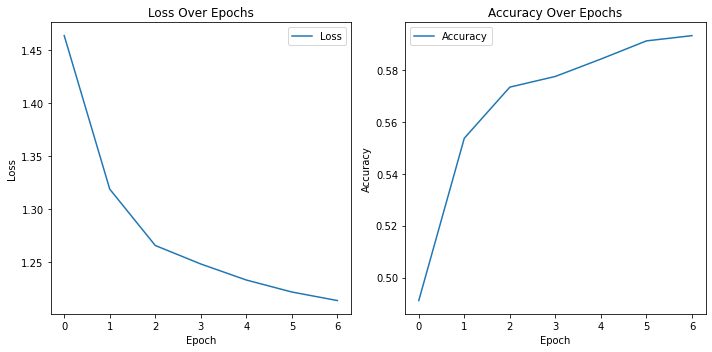

Class: anger
Precision: 0.4482
Recall: 0.3807
F1 Score: 0.4117

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.6400
Recall: 0.3707
F1 Score: 0.4695

Class: neutral
Precision: 0.6157
Recall: 0.9413
F1 Score: 0.7445

Class: sadness
Precision: 0.2500
Recall: 0.0011
F1 Score: 0.0023

Class: surprise
Precision: 0.5998
Recall: 0.4477
F1 Score: 0.5127

Class: macro avg
Precision: 0.3648
Recall: 0.3059
F1 Score: 0.3058

Class: weighted avg
Precision: 0.5401
Recall: 0.6002
F1 Score: 0.5378

Accuracy: 0.6002
Weighted F1 Score: 0.5378
Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 216]) torch.Size([3400])
Class: anger
Precision: 0.5023
Recall: 0.4186
F1 Score: 0.4567

Class: disgust
Precision: 0.0000
Recall: 0.0000
F

C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2974198338.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures2), y_test, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tenso

In [164]:
X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures2), y_train, False)
model = model_train1(X_trainTensor,Y_trainTensor, 40, 64)

classify_emotions(model, X_trainTensor, Y_trainTensor, False)

X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures2), y_test, False)
classify_emotions(model, X_testTensor, Y_testTensor, False)

C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\396841405.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures2), y_train, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.te

Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 216]) torch.Size([12840])


Epoch 1/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:00<00:00, 214.09batch/s, loss=1.56]


Epoch 1 finished with average loss: 1.5491


Epoch 2/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:00<00:00, 224.17batch/s, loss=1.48]


Epoch 2 finished with average loss: 1.4383


Epoch 3/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:00<00:00, 226.43batch/s, loss=1.18]


Epoch 3 finished with average loss: 1.3811


Epoch 4/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 197.53batch/s, loss=1.08]


Epoch 4 finished with average loss: 1.3541


Epoch 5/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 190.93batch/s, loss=1.18]


Epoch 5 finished with average loss: 1.3236


Epoch 6/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 190.14batch/s, loss=1.23]


Epoch 6 finished with average loss: 1.3103


Epoch 7/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 191.56batch/s, loss=1.09]


Epoch 7 finished with average loss: 1.2886


Epoch 8/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 188.21batch/s, loss=1.39]


Epoch 8 finished with average loss: 1.2780


Epoch 9/40: 100%|██████████████████████████████████████████████████████| 201/201 [00:01<00:00, 190.70batch/s, loss=1.1]


Epoch 9 finished with average loss: 1.2714
Early stopping at epoch 9 due to minimal loss improvement
Finished Training


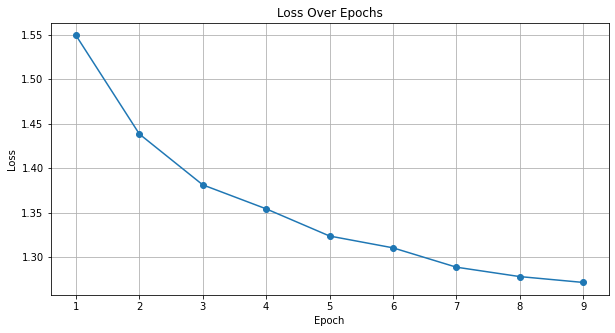

Class: anger
Precision: 0.4736
Recall: 0.2273
F1 Score: 0.3072

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.5404
Recall: 0.4079
F1 Score: 0.4649

Class: neutral
Precision: 0.6172
Recall: 0.9334
F1 Score: 0.7431

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.4912
Recall: 0.4490
F1 Score: 0.4691

Class: macro avg
Precision: 0.3032
Recall: 0.2882
F1 Score: 0.2835

Class: weighted avg
Precision: 0.4961
Recall: 0.5854
F1 Score: 0.5190

Accuracy: 0.5854
Weighted F1 Score: 0.5190
Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 216]) torch.Size([3400])
Class: anger
Precision: 0.5419
Recall: 0.2384
F1 Score: 0.3311

Class: disgust
Precision: 0.0000
Recall: 0.0000
F

C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\396841405.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures2), y_test, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor

In [165]:
X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures2), y_train, False)
model = model_train2(X_trainTensor,Y_trainTensor, 40, 64)

classify_emotions(model, X_trainTensor, Y_trainTensor, False)

X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures2), y_test, False)
classify_emotions(model, X_testTensor, Y_testTensor, False)

C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\3582582597.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures5), y_train, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.t

Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 222]) torch.Size([12840])


Epoch 1/40:   0%|                                                                            | 0/12840 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\3359458753.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\3359458753.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/40], Loss: 1.4612, Accuracy: 0.4917


Epoch [2/40], Loss: 1.3253, Accuracy: 0.5513


Epoch [3/40], Loss: 1.2747, Accuracy: 0.5707


Epoch [4/40], Loss: 1.2493, Accuracy: 0.5787


Epoch [5/40], Loss: 1.2367, Accuracy: 0.5862


Epoch [6/40], Loss: 1.2254, Accuracy: 0.5897


Epoch [7/40], Loss: 1.2146, Accuracy: 0.5939


Epoch [8/40], Loss: 1.2085, Accuracy: 0.5956
Training terminated early at epoch 8 due to small change in loss


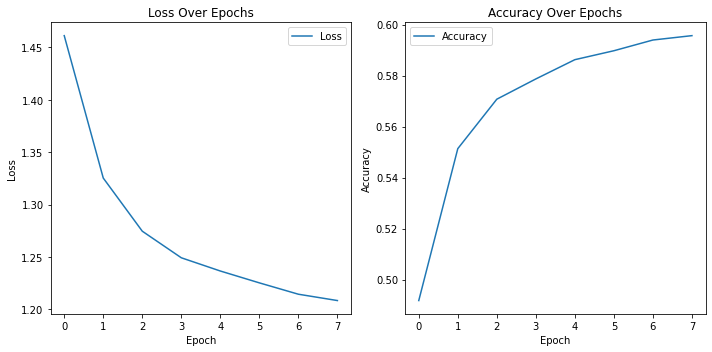

Class: anger
Precision: 0.4773
Recall: 0.3160
F1 Score: 0.3803

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.6234
Recall: 0.3845
F1 Score: 0.4757

Class: neutral
Precision: 0.6276
Recall: 0.9336
F1 Score: 0.7506

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.5251
Recall: 0.5483
F1 Score: 0.5364

Class: macro avg
Precision: 0.3219
Recall: 0.3118
F1 Score: 0.3061

Class: weighted avg
Precision: 0.5203
Recall: 0.6031
F1 Score: 0.5407

Accuracy: 0.6031
Weighted F1 Score: 0.5407
Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 222]) torch.Size([3400])
Class: anger
Precision: 0.5121
Recall: 0.3275
F1 Score: 0.3995

Class: disgust
Precision: 0.0000
Recall: 0.0000
F

C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\3582582597.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures5), y_test, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tenso

In [168]:
X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures5), y_train, False)
model = model_train1(X_trainTensor,Y_trainTensor, 40, 64)

classify_emotions(model, X_trainTensor, Y_trainTensor, False)

X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures5), y_test, False)
classify_emotions(model, X_testTensor, Y_testTensor, False)

C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\396841405.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures2), y_train, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.te

Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 216]) torch.Size([12840])


Epoch 1/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:00<00:00, 240.07batch/s, loss=1.65]


Epoch 1 finished with average loss: 1.5412


Epoch 2/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:00<00:00, 235.14batch/s, loss=1.17]


Epoch 2 finished with average loss: 1.4321


Epoch 3/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:00<00:00, 235.75batch/s, loss=1.56]


Epoch 3 finished with average loss: 1.3799


Epoch 4/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 200.43batch/s, loss=1.51]


Epoch 4 finished with average loss: 1.3392


Epoch 5/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 180.84batch/s, loss=1.47]


Epoch 5 finished with average loss: 1.3164


Epoch 6/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 183.01batch/s, loss=1.45]


Epoch 6 finished with average loss: 1.3004


Epoch 7/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 194.16batch/s, loss=1.42]


Epoch 7 finished with average loss: 1.2857


Epoch 8/40: 100%|█████████████████████████████████████████████████████| 201/201 [00:01<00:00, 185.89batch/s, loss=1.39]


Epoch 8 finished with average loss: 1.2776
Early stopping at epoch 8 due to minimal loss improvement
Finished Training


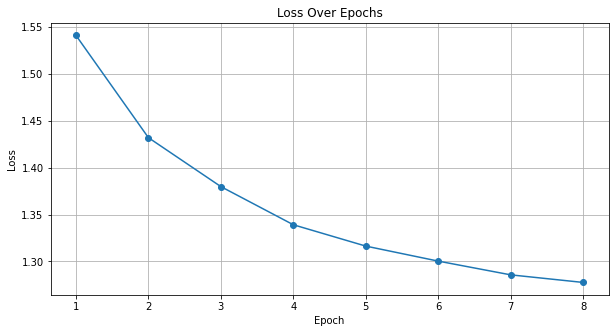

Class: anger
Precision: 0.4864
Recall: 0.1673
F1 Score: 0.2490

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.4651
Recall: 0.4728
F1 Score: 0.4689

Class: neutral
Precision: 0.6152
Recall: 0.9357
F1 Score: 0.7424

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.5325
Recall: 0.3248
F1 Score: 0.4035

Class: macro avg
Precision: 0.2999
Recall: 0.2715
F1 Score: 0.2663

Class: weighted avg
Precision: 0.4879
Recall: 0.5767
F1 Score: 0.5049

Accuracy: 0.5767
Weighted F1 Score: 0.5049
Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 216]) torch.Size([3400])
Class: anger
Precision: 0.5425
Recall: 0.1609
F1 Score: 0.2481

Class: disgust
Precision: 0.0000
Recall: 0.0000
F

C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\396841405.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures2), y_test, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor

In [167]:
X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures5), y_train, False)
model = model_train2(X_trainTensor,Y_trainTensor, 40, 64)

classify_emotions(model, X_trainTensor, Y_trainTensor, False)

X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures5), y_test, False)
classify_emotions(model, X_testTensor, Y_testTensor, False)

C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\3703393720.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures6), y_train, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.t

Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 207]) torch.Size([12840])


Epoch 1/40:   0%|                                                                            | 0/12840 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\3359458753.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\3359458753.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/40], Loss: 1.4638, Accuracy: 0.4891


Epoch [2/40], Loss: 1.3291, Accuracy: 0.5489


Epoch [3/40], Loss: 1.2753, Accuracy: 0.5688


Epoch [4/40], Loss: 1.2501, Accuracy: 0.5804


Epoch [5/40], Loss: 1.2356, Accuracy: 0.5847


Epoch [6/40], Loss: 1.2254, Accuracy: 0.5906


Epoch [7/40], Loss: 1.2156, Accuracy: 0.5959
Training terminated early at epoch 7 due to small change in loss


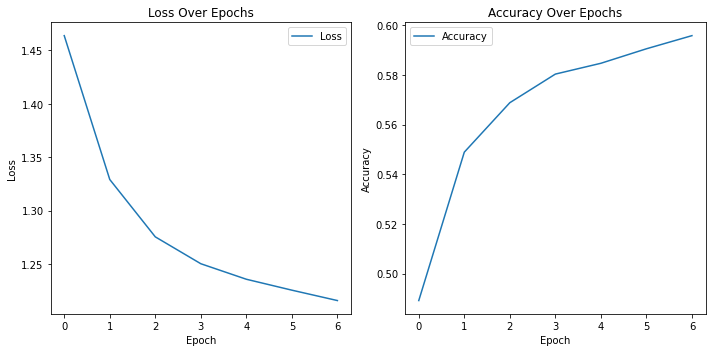

In [153]:
X_trainTensor, Y_trainTensor = prep_data(torch.tensor(concatenatedTrainFeatures6), y_train, False)
model = model_train1(X_trainTensor,Y_trainTensor, 40, 64)

In [154]:
classify_emotions(model, X_trainTensor, Y_trainTensor, False)

Class: anger
Precision: 0.4357
Recall: 0.3680
F1 Score: 0.3990

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.6598
Recall: 0.3456
F1 Score: 0.4536

Class: neutral
Precision: 0.6303
Recall: 0.9289
F1 Score: 0.7510

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.5193
Recall: 0.5503
F1 Score: 0.5344

Class: macro avg
Precision: 0.3207
Recall: 0.3133
F1 Score: 0.3054

Class: weighted avg
Precision: 0.5225
Recall: 0.6002
F1 Score: 0.5389

Accuracy: 0.6002
Weighted F1 Score: 0.5389


In [155]:
X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures6), y_test, False)
classify_emotions(model, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 207]) torch.Size([3400])
Class: anger
Precision: 0.4976
Recall: 0.4012
F1 Score: 0.4442

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.5770
Recall: 0.4465
F1 Score: 0.5034

Class: neutral
Precision: 0.6842
Recall: 0.8625
F1 Score: 0.7631

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.3982
Recall: 0.6392
F1 Score: 0.4907

Class: macro avg
Precision: 0.3081
Recall: 0.3356
F1 Score: 0.3145

Class: weighted avg
Precision: 0.5257
Recall: 0.6018
F1 Score: 0.5540

Accuracy: 0.6018
Weighted F1 Score: 0.5540


C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\512766527.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_testTensor, Y_testTensor = prep_data(torch.tensor(concatenatedTestFeatures6), y_test, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_11528\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor

<h4> Train and validate CNNBiLSTM+EGAT

(12840, 134)

C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\1375589347.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_trainTensor, Y_trainTensor = prep_data(torch.tensor(trainFeatures6), y_train, False)
C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.

Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 64]) torch.Size([12840])


Epoch 1/50:   0%|                                                                                | 0/12840 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\1948670983.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_10832\1948670983.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/50], Loss: 1.5792, Accuracy: 0.4616


Epoch [2/50], Loss: 1.5582, Accuracy: 0.4642


Epoch [3/50], Loss: 1.5591, Accuracy: 0.4642
Training terminated early at epoch 3 due to small change in loss


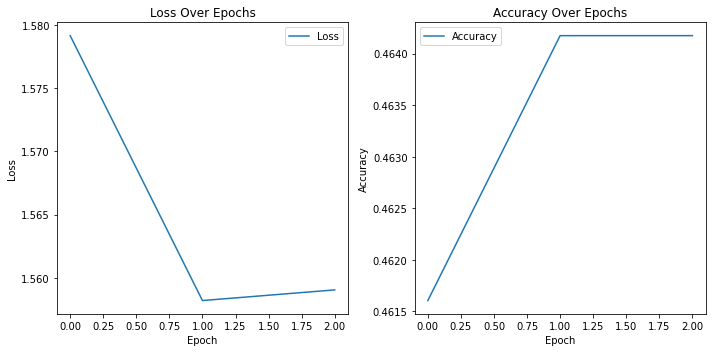

Train CNNBiLSTM+EGAT given 15 epochs - Elapsed time: 108.74697637557983 seconds
Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 64]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.4750
Recall: 1.0000
F1 Score: 0.6441

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: macro avg
Precision: 0.0679
Recall: 0.1429
F1 Score: 0.0920

Class: weighted avg
Precision: 0.2256
Recall: 0.4750
F1 Score: 0.3059

Accuracy: 0.4750
Weighted F1 Score: 0.3059


In [48]:
# enable oversampling by setting isOversample=True
X_trainTensor, Y_trainTensor = prep_data(torch.tensor(trainFeatures6), y_train, False)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=50, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Train CNNBiLSTM+EGAT given 15 epochs - Elapsed time: {elapsed_time} seconds")
X_testTensor, Y_testTensor = prep_data(testFeatures6, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 600]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.4750
Recall: 1.0000
F1 Score: 0.6441

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: macro avg
Precision: 0.0679
Recall: 0.1429
F1 Score: 0.0920

Class: weighted avg
Precision: 0.2256
Recall: 0.4750
F1 Score: 0.3059

Accuracy: 0.4750
Weighted F1 Score: 0.3059


C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


<h4> Train and validate CNNBiLSTM+GAT (⭕️ Oversample)

C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 5960 occurrences
Label disgust: 5960 occurrences
Label fear: 5960 occurrences
Label joy: 5960 occurrences
Label neutral: 5960 occurrences
Label sadness: 5960 occurrences
Label surprise: 5960 occurrences
torch.Size([41720, 600]) torch.Size([41720])


Epoch 1/11:   0%|                                                                            | 0/41720 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\3756449778.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\3756449778.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/11], Loss: 0.5595, Accuracy: 0.8228


Epoch [2/11], Loss: 0.5732, Accuracy: 0.8187
Training terminated early at epoch 2 due to small change in loss


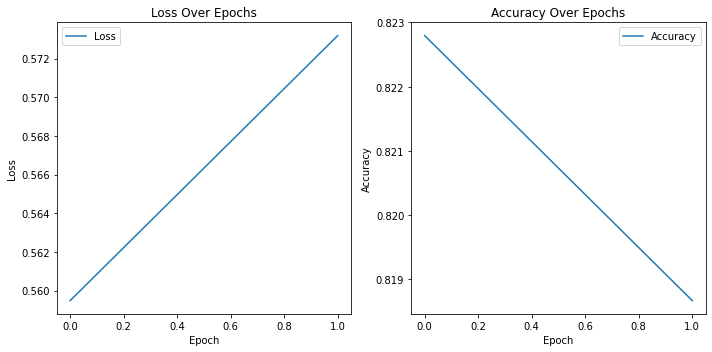

Trai CNNBiLSTM+GAT given 15 epochs - Elapsed time: 869.8773131370544 seconds
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1429
Recall: 1.0000
F1 Score: 0.2500

Class: macro avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Class: weighted avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Accuracy: 0.1429
Weighted F1 Score: 0.0357


In [40]:
X_trainTensor, Y_trainTensor = prep_data(concatenatedRepresentationTrain1, y_train, True)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=11, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Trai CNNBiLSTM+GAT given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [42]:
# Predict the test set
X_testTensor, Y_testTensor = prep_data(concatenatedRepresentationTest1, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 600]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1035
Recall: 1.0000
F1 Score: 0.1876

Class: macro avg
Precision: 0.0148
Recall: 0.1429
F1 Score: 0.0268

Class: weighted avg
Precision: 0.0107
Recall: 0.1035
F1 Score: 0.0194

Accuracy: 0.1035
Weighted F1 Score: 0.0194


C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


<h4> Train and validate CNNBiLSTM (❌ feature selection ⭕️ Oversample) given 2 epochs

C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 5960 occurrences
Label disgust: 5960 occurrences
Label fear: 5960 occurrences
Label joy: 5960 occurrences
Label neutral: 5960 occurrences
Label sadness: 5960 occurrences
Label surprise: 5960 occurrences
torch.Size([41720, 300]) torch.Size([41720])


Epoch 1/11:   0%|                                                                            | 0/41720 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\3756449778.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\3756449778.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/11], Loss: 0.5492, Accuracy: 0.8229


Epoch [2/11], Loss: 0.5942, Accuracy: 0.8044
Training terminated early at epoch 2 due to small change in loss


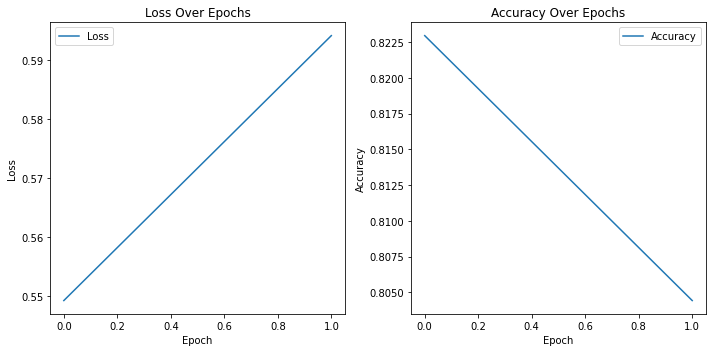

Training CNNBiLSTM given 15 epochs - Elapsed time: 612.7316813468933 seconds
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1429
Recall: 1.0000
F1 Score: 0.2500

Class: macro avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Class: weighted avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Accuracy: 0.1429
Weighted F1 Score: 0.0357


In [43]:
X_trainTensor, Y_trainTensor = prep_data(rawCtxRepresentationTrain, y_train, True)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=11, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training CNNBiLSTM given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [44]:
# Predict the test set
X_testTensor, Y_testTensor = prep_data(rawCtxRepresentationTest, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 300]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1035
Recall: 1.0000
F1 Score: 0.1876

Class: macro avg
Precision: 0.0148
Recall: 0.1429
F1 Score: 0.0268

Class: weighted avg
Precision: 0.0107
Recall: 0.1035
F1 Score: 0.0194

Accuracy: 0.1035
Weighted F1 Score: 0.0194


C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


<h4> Train and validate BERT+EGAT (⭕️ feature selection, ⭕️ Oversample) given 11 epochs

C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 5960 occurrences
Label disgust: 5960 occurrences
Label fear: 5960 occurrences
Label joy: 5960 occurrences
Label neutral: 5960 occurrences
Label sadness: 5960 occurrences
Label surprise: 5960 occurrences
torch.Size([41720, 131]) torch.Size([41720])


Epoch 1/5:   0%|                                                                             | 0/41720 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\1948670983.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\1948670983.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/5], Loss: 0.7708, Accuracy: 0.7471


Epoch [2/5], Loss: 0.7725, Accuracy: 0.7529
Training terminated early at epoch 2 due to small change in loss


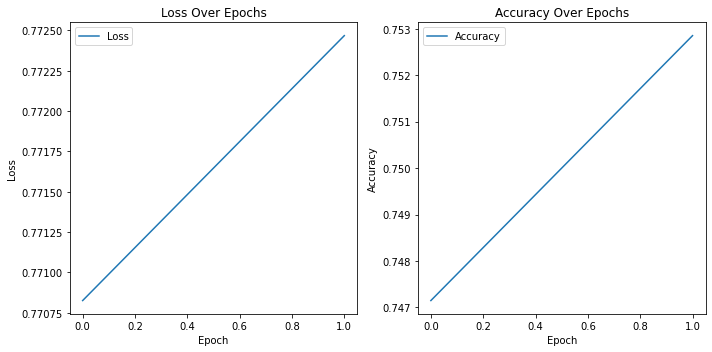

Training CNNBiLSTM given 15 epochs - Elapsed time: 310.8277277946472 seconds
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1429
Recall: 1.0000
F1 Score: 0.2500

Class: macro avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Class: weighted avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Accuracy: 0.1429
Weighted F1 Score: 0.0357


In [56]:
X_trainTensor, Y_trainTensor = prep_data(concatenatedSelectedRepresentationTrain1, y_train, True)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=5, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training CNNBiLSTM given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [ ]:
# # Predict the test set
X_testTensor, Y_testTensor = prep_data(concatenatedSelectedRepresentationTest1, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

<h4> Train and validate BERT+EGAT (⭕️ feature selection, ❌ Oversample) given 11 epochs¶

C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 131]) torch.Size([12840])


Epoch 1/11:   0%|                                                                            | 0/12840 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\1948670983.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\1948670983.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/11], Loss: 1.5805, Accuracy: 0.4622


Epoch [2/11], Loss: 1.5517, Accuracy: 0.4642


Epoch [3/11], Loss: 1.5454, Accuracy: 0.4642
Training terminated early at epoch 3 due to small change in loss


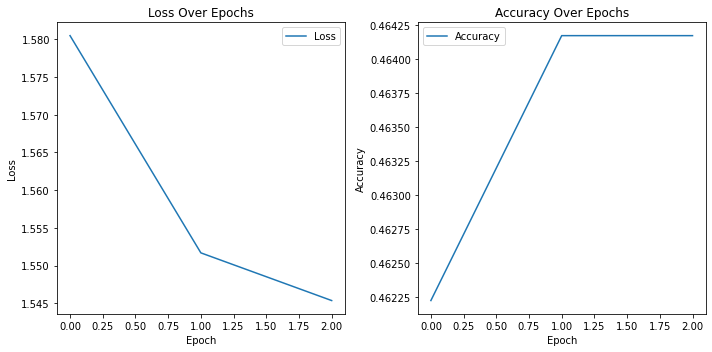

Training CNNBiLSTM given 15 epochs - Elapsed time: 107.85777187347412 seconds
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.4642
Recall: 1.0000
F1 Score: 0.6340

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: macro avg
Precision: 0.0663
Recall: 0.1429
F1 Score: 0.0906

Class: weighted avg
Precision: 0.2155
Recall: 0.4642
F1 Score: 0.2943

Accuracy: 0.4642
Weighted F1 Score: 0.2943


In [53]:
X_trainTensor, Y_trainTensor = prep_data(concatenatedSelectedRepresentationTrain1, y_train, False)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=11, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training CNNBiLSTM given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [54]:
# # Predict the test set
X_testTensor, Y_testTensor = prep_data(concatenatedSelectedRepresentationTest1, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 131]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.4750
Recall: 1.0000
F1 Score: 0.6441

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: macro avg
Precision: 0.0679
Recall: 0.1429
F1 Score: 0.0920

Class: weighted avg
Precision: 0.2256
Recall: 0.4750
F1 Score: 0.3059

Accuracy: 0.4750
Weighted F1 Score: 0.3059


C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_21404\2151628629.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()
